# fft score cam implementation


### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import wandb
import pickle
#from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import transform
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import cv2
from plotting_utils import RF_Visualizer
import pandas as pd
from scipy.fft import fft, ifft,fftshift
import os
import math
from scipy import signal

cur_dir = os.getcwd()
print(cur_dir)



/home/sagetrudeau/Projects/XAI/RF-Models-CAM-Evaluation


### Class and Function Definitions

In [2]:

# def test_in_distribution(model, dataset):
#     dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
#     slice_accs = []
#     example_majority_accs = []
#     example_sum_accs = []
#     for i, (trans, label) in enumerate(dataloader):
#         # print(i, len(dataset))
#         trans, label = trans[0].cuda(), label[0].cuda()
#         with torch.no_grad():
#             pred = model(trans)
#             pred_class = torch.argmax(pred, dim=-1)
#         accuracy = torch.mean((pred_class == label).float()).cpu().numpy()
#         majority_accuracy = (torch.mode(pred_class)[0] == label).float().cpu().numpy()
#         sum_accuracy = (torch.argmax(torch.sum(pred, dim=0)) == label).float().cpu().numpy()
#         slice_accs.append(accuracy)
#         example_majority_accs.append(majority_accuracy)
#         example_sum_accs.append(sum_accuracy)
#     return np.mean(np.asarray(slice_accs)), np.mean(np.asarray(example_majority_accs)), np.mean(
#         np.asarray(example_sum_accs))


class CamExtractor():
    """
        Extracts cam features from the model, this one is for AlexNet1D. May need to be tweaked for other models
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.feature_extractor._modules.items():
            x = module(x)  # Forward
            #print(x)
            if int(module_pos) == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        x = x.to('cpu')
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.fc2(F.relu(self.model.fc1(x)))
        # x = self.model.classifier(x)
        return conv_output, x


class SCORECAM_1dcnn():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer, slice_size):
        self.model = model
        self.target_layer = target_layer
        self.slice_size = slice_size
        self.model.eval() #set dropout and batch norm layers to evaluation mode before running inferance
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_slice, target_class=None):
        # Score-CAM
        ## The implementation was derived from https://github.com/tabayashi0117/Score-CAM and modified under MIT license

        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model 
        #extractor = CamExtractor(model, target_layer)
        input_slice = input_slice.to('cpu')
        conv_output, model_output = self.extractor.forward_pass(input_slice)
        #print(model_output)
        if target_class is None:
            target_class = np.argmax(F.softmax(model_output).to('cpu').data.numpy())
        pred = F.softmax(model_output,dim=1)[0]
        print(pred)
        pred_class = pred[target_class].to('cpu').data.numpy()
       
        # Get convolution outputs
        target = conv_output[0]
        target = F.relu(target)
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        #print(len(target))
        test_var_weights = []
        input_response_logit_Xb = F.softmax(self.extractor.forward_pass(input_slice)[1],dim=1)[0][target_class].to('cpu').data.numpy()
        validate_cam_masks = []
        validate_cam_Sc = []
        validate_cam_Al_k = []
        for i in range(len(target)): #iterate over each activation map
            # Unsqueeze
            saliency_map = torch.unsqueeze(torch.unsqueeze(target[i,:],0),0)
            #print("salmap",saliency_map.shape)
            # Upsampling to input size, from output feature size of 4 to 256 in this case
            saliency_map = F.interpolate(saliency_map, size=(self.slice_size), mode='linear', align_corners=False)
            if saliency_map.max() == saliency_map.min():
                continue
            # Scale between 0-1
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            #print(norm_saliency_map)
            # Get the target score
            X_Hl =input_slice*norm_saliency_map
            validate_cam_masks.append(X_Hl)
            validate_cam_Al_k.append(target[i, :].to('cpu').data.numpy())
            
            activation_map_score = self.extractor.forward_pass(X_Hl)[1]
            w = F.softmax(activation_map_score,dim=1)[0]
            w_class =w[target_class]
            validate_cam_Sc.append(w_class)
            test_var_weights.append(w_class)
            #print("w_class",w_class)
            cam += w_class.to('cpu').data.numpy() * target[i, :].to('cpu').data.numpy() #experimenting with implementation
            #cam += w_class.data.numpy() * saliency_map.data.numpy()

            #print("cam",cam)
        cam_final = transform.resize(cam, (self.slice_size,))
        cam_final = np.maximum(cam_final, 0)
        # print("target",target)
        # print("cam2",cam_final)
        # if np.min(cam_final) != np.max(cam_final):
        #     cam_final = (cam_final - np.min(cam_final)) / (np.max(cam_final) - np.min(cam_final))  # Normalize between 0-1
        # else:
        #     cam_final = (cam_final - np.min(cam_final)) 

        # #validation to original paper, can use either cam_final or cam_validation 
        # S_c = [x.detach().to('cpu').numpy()-input_response_logit_Xb for x in validate_cam_Sc]
        # #print("s_c", S_c)
        # sum_alpha_cks = sum([math.exp(x)for x in S_c])
        # alpha_ck = [math.exp(x)/sum_alpha_cks for x in S_c]
        # #print("alpha_ck", alpha_ck, sum(alpha_ck))

        # cam_validation=np.ones(target.shape[1:], dtype=np.float32)
        # #print(validate_cam_Al_k)
        # for i in range(len(alpha_ck)):
        #     feature_cam_part=alpha_ck[i]*validate_cam_Al_k[i]
        #     #print(feature_cam_part)
        #     cam_validation += feature_cam_part
        #     #print(cam_validation)
        # cam_validation = transform.resize(cam_validation, (self.slice_size,))
        # cam_validation = np.maximum(cam_validation, 0) #ReLu
        
        return cam_final,pred_class
    
    def frequency_ablation_cam(self,input_slice, target_class, num_freq_divisions, filter_method='rectangular'):
        '''
        Estimates the importance of particular frequency regions towards the classifcation score for a target class at a target layer
        '''

        #TODO: option to replace notch filtered section with just noise but maintain signal power

        conv_output, model_output = self.extractor.forward_pass(input_slice)
        base_accuracy = F.softmax(model_output,dim=1)[0]
        base_accuracy = base_accuracy[target_class].to('cpu').data.numpy()

        # Combine I and Q channels into a complex number
        #input_slice = input_slice.squeeze(0).transpose(0, 1)
        input_complex = input_slice[0].to('cpu').data.numpy()[0] + 1j*input_slice[0].to('cpu').data.numpy()[1]
        
        # Convert to numpy and apply FFT
        input_fft = fft(input_complex) #default to fft size = len input

        # Length of each frequency division
        division_length = input_fft.shape[0] // num_freq_divisions

        accuracy_weights = []

        for i in range(num_freq_divisions):
            # Create a copy of the frequency domain representation
            modified_fft = np.copy(input_fft)

            # Calculate start and end indices for the current division
            start_idx = i * division_length
            end_idx = start_idx + division_length

            # Apply notch filter (zero out the selected frequency band)
            if filter_method == 'rectangular':
                modified_fft[start_idx:end_idx] = 0
            else:
                print('Filter method: ', filter_method, " not recognized")
                raise

            # Convert back to time domain
            modified_time_domain = ifft(modified_fft)

            # Separate back into I and Q channels
            modified_I = np.real(modified_time_domain)
            modified_Q = np.imag(modified_time_domain)

            # Convert to tensors and expand dimensions as needed for the model
            input_tensor_I = torch.from_numpy(modified_I).float()
            input_tensor_Q = torch.from_numpy(modified_Q).float()
            modified_input_tensor = torch.stack([input_tensor_I, input_tensor_Q], dim=0)
            modified_input_tensor = modified_input_tensor.expand(1, -1, -1)

            # Generate CAM and record accuracy
            score_pred = self.extractor.forward_pass(modified_input_tensor)[1]
            accuracy_weight= F.softmax(score_pred,dim=1)[0][target_class].to('cpu').data.numpy()
            accuracy_weights.append(accuracy_weight)


        #calculate freq cam response as the drop in accuracy due to removal of frequency division
        cam_responses = [abs(base_accuracy - acc) for acc in accuracy_weights ]

        return cam_responses




### Load Data
Import data using whatever torch dataloader your original model utilized. 

In [3]:

if __name__ == "__main__":
    from model import Baseline_CNN1D
    from dataset_tprime import TPrimeDataset
    import argparse
    from scipy.io import loadmat


    # seqs = {}
    # with open("/home/sagetrudeau/Datasets/ORACLE/mat_files/raw/train.pkl", "rb") as f:#Oracle
    # #with open("/raid/backup_storage_oldDGX/LORA/Year_1_outdoor/outdoor_dataset_1/mat_files/raw/train.pkl", "rb") as f:
    #     file_dict = pickle.load(f)
    # filenames = file_dict["files"]
    # print(filenames)
    # for i, name in enumerate(filenames):
    #     #print(i, len(filenames))
    #     seqs[name] = loadmat(name)["f_sig"][0]
    # #dataset = InDistributionTestDataset(seqs,"val")
    # dataset = InDistributionTestDatasetContinuous(seqs, "val")
    # #dataset = InDistributionTrainDataset(seqs)
    # train_dataset = InDistributionTrainDataset(seqs)
    # del seqs
    args=argparse.Namespace()
    args.protocols = ['802_11ax', '802_11b_upsampled', '802_11n', '802_11g']
    args.noise = True
    args.snr_db = [30]
    args.raw_path = "/home/sagetrudeau/Projects/t-prime/data/DATASET1_1"
    args.slicelen = 512
    args.overlap_ratio = 0.0
    args.postfix = ''
    args.raw_data_ratio = 1.0
    args.channel = None
    args.out_mode = 'real'
    args.worker_batch_size = 512

    ds_test = TPrimeDataset(args.protocols,
                          ds_path=args.raw_path,
                          ds_type='test',
                          snr_dbs=args.snr_db,
                          slice_len=args.slicelen,
                          slice_overlap_ratio=float(args.overlap_ratio),
                          raw_data_ratio=args.raw_data_ratio,
                          file_postfix=args.postfix,
                          override_gen_map=False,    # it will use the same as above call
                          apply_wchannel=args.channel,
                          apply_noise=args.noise,
                          out_mode=args.out_mode)
    dataloader = DataLoader(ds_test, batch_size=args.worker_batch_size, shuffle=False)


### Load model


Baseline_CNN1D(
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(1,))
  (relu1): ReLU()
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (feature_extractor): ModuleList(
    (0): Conv1d(2, 64, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16000, out_features=256, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)
sig_len: 29280


/home/sagetrudeau/Projects/XAI/xai_venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


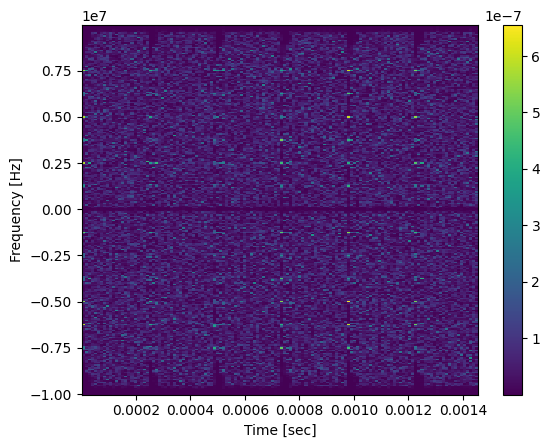

tensor([[-1.2875e-05, -3.6265e+01, -1.7358e+01, -1.1257e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-5.9605e-07, -2.5799e+01, -1.4261e+01, -4.4459e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-5.9605e-07, -2.3293e+01, -1.4400e+01, -5.1703e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-3.5763e-07, -1.9788e+01, -1.4931e+01, -5.1264e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-3.5763e-07, -2.0247e+01, -1.5001e+01, -4.9116e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-3.5763e-06, -1.7325e+01, -1.2542e+01, -4.6197e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-7.0569e-05, -1.7790e+01, -9.5596e+00, -3.6806e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-1.1921e-06, -1.8337e+01, -1.3616e+01, -4.3215e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[  0.0000, -20.3844, -19.3534, -59.4047]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([[-6.9139e-05, -2.8953e+01, -9.5793e+00, -2.5038e+01]],
       grad_fn=<LogSoftmaxBackward0>)
te

<Figure size 640x480 with 0 Axes>

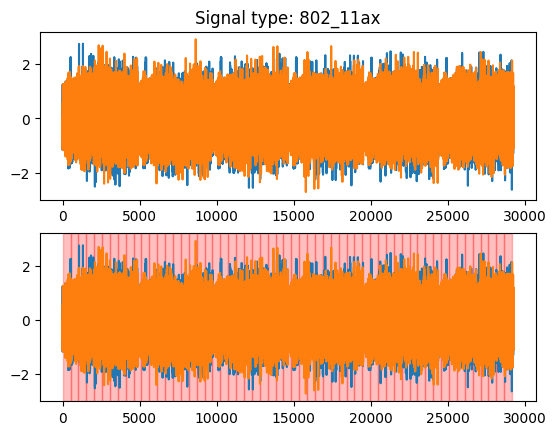

<Figure size 640x480 with 0 Axes>

In [4]:

#experiment 
#model=torch.load("model/ORACLE_Original_4.weights").cpu()

# model = AlexNet1D(train_dataset.num_classes)#.cuda()
# #model.load_state_dict(torch.load("/model/ORACLE_z_score_6.weights"))#Oracle
# #model.eval() #set dropout and batch norm layers to evaluation mode before running inferance
# model=torch.load(cur_dir+"/model/ORACLE_6_Dev_MinMax_1.weights").cpu()
# model.eval()
# print(model)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

#t-prime
PATH = './results/t-prime/SNR30/'
Nclass = 4
num_channels = 2
num_feats = 1
slice_len = 512

device = torch.device('cpu')
model = Baseline_CNN1D(classes=Nclass, numChannels=num_channels, slice_len=slice_len)
checkpoint = torch.load(cur_dir+"/model/model.baseline_cnn1d.nochan.range.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device) # reload the model on the appropriate device
model.device = device
model.eval()    # set the evaluation mode
print(model)

#parameters for test
#input_image = resized_slice
target_class = 3 
target_layer = 4
#number of sections to divide freq spectrum into for freq_ablation cam
num_freq_divisions = 16 
sample_test_idx= 175475 #175475 is a 802.11ax #100000 is 802.11g
sample_rate = 11e6

# for i, (trans, label) in enumerate(dataloader):#hardcoded change
#     #trans, label = trans[0].cuda(), label[0].cuda()
#     if i == sample_test_idx:
#         trans, label = trans[0], label[0]
#         # slice_of_trans = trans[0,:,:]
#         # # slice_of_trans[0,0:30] = torch.Tensor([np.random.randn(30)/2])
#         # # slice_of_trans[1,0:30] = torch.Tensor([np.random.randn(30)/2])
#         # input_slice=slice_of_trans.expand(1,-1,-1)
#         #pred = F.softmax(model(input_slice))
#         #print(pred)
#         #pred_class = torch.argmax(pred, dim=-1)

#         rf_visualizer = RF_Visualizer(trans,label,sample_rate)

#         break
def find_label(class_map, true_label):

    for k, v in class_map.items():
        if v == true_label:
            label_txt = k
            break
    return label_txt

plot_dir = os.path.join(PATH, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# for _ in range(30):
#     # obtain a random sample from the test dataset. This will be needed in order to populate the cache initially
#     rand_sixs = np.random.choice(len(ds_test))
rand_sixs = sample_test_idx
_, true_label = ds_test[rand_sixs]
# now let's retrieve the whole signal from the signal cache
signal_path = ds_test.last_file_loaded
#print(signal_path)
# let's obtain the whole signal and run inference on each slice
sig = ds_test.signal_cache.cache[signal_path]['np']

#print(sig)
# apply AWGN
noisy_sig = ds_test.apply_AWGN(sig)
len_sig = noisy_sig.shape[0]
window_ixs = list(range(0, len_sig-ds_test.slice_len, ds_test.overlap))

#plot to spot check
trans=np.squeeze(sig) #TODO: fix variable names from this lazy doublecast
label =true_label
fs = 20e6 if true_label != 1 else 11e6
sample_rate = fs
rf_visualizer = RF_Visualizer(trans,label,sample_rate)
print("sig_len:",len(sig))

f, t, Sxx = signal.spectrogram(np.squeeze(noisy_sig), fs)
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0)) # cmap='afmhot'
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

plt.savefig(os.path.join(plot_dir, str(rand_sixs)+'ex_' + find_label(ds_test.ds_info['class_map'], true_label) + '_spectrogram.png'))

plt.clf()

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(noisy_sig.real)
ax1.plot(noisy_sig.imag)
ax1.set_title('Signal type: '+ find_label(ds_test.ds_info['class_map'], true_label))
ax2.plot(noisy_sig.real)
ax2.plot(noisy_sig.imag)



color_class = ['red', 'green', 'blue', 'yellow']
many_slice_ts=[]
for w in window_ixs:
    complex_slice = noisy_sig[w : w + ds_test.slice_len, 0]
    slice = np.stack((complex_slice.real, complex_slice.imag))
    slice = slice[np.newaxis, :, :]
    slice_t = torch.Tensor(slice)
    many_slice_ts.append(slice_t)
    slice_t = slice_t.to(model.device.type)
    out = model(slice_t.float())
    print(out)
    _, predicted = torch.max(out, 1)
    ax2.axvspan(w, w + ds_test.slice_len, color=color_class[predicted], alpha=0.25)

plt.show()
plt.savefig(os.path.join(plot_dir, str(rand_sixs)+'ex_' + find_label(ds_test.ds_info['class_map'], true_label) + '_wavetag.png'))
plt.clf()




### Spot Check Data

In [5]:

# #check data
# rf_visualizer.plotSpectrogram(fftWindow='rectangular', fftSize=128, winLen = 128,overlap=127)
# #rf_visualizer.plotSpectrogramArlpy(fftSize=2048,cLim=30)
# rf_visualizer.plotPSD(fftWindow='blackman', fftSize=2048)


### Create Class Activation Maps

og tensor([[[ 4.2020e-01, -1.1695e+00, -1.4896e-01,  ..., -4.8167e-02,
          -3.3987e-02,  8.8327e-02],
         [ 5.4617e-01,  1.3871e-04, -6.7437e-01,  ...,  1.3946e-01,
           5.1587e-01,  1.5372e+00]]])
Original Prediction [[-1.28745205e-05 -3.62649078e+01 -1.73578148e+01 -1.12571478e+01]]
Powers: 0 485.65576 1007.705331999553 485.65576171874994
Aug Prediction [[  0.       -22.175856 -30.440325 -64.57601 ]]
tensor([1.0000e+00, 2.3396e-10, 6.0247e-14, 9.0156e-29],
       grad_fn=<SelectBackward0>)
og tensor([[[ 2.1449, -0.8292,  0.7194,  ...,  1.0461, -0.3053, -1.4613],
         [ 0.8017,  0.7407,  0.0188,  ..., -0.4859,  0.4002,  0.7359]]])
Original Prediction [[-5.9604628e-07 -2.5799345e+01 -1.4261222e+01 -4.4459305e+01]]
Powers: 1 512.49854 1061.2290071237314 512.49853515625
Aug Prediction [[  0.       -19.432789 -29.756416 -67.161804]]
tensor([1.0000e+00, 3.6345e-09, 1.1939e-13, 6.7920e-30],
       grad_fn=<SelectBackward0>)
og tensor([[[-0.8383,  0.0040, -0.4875,  ..., 

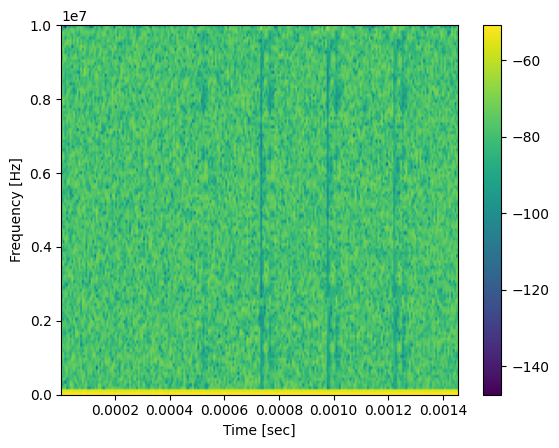

/home/sagetrudeau/Projects/XAI/xai_venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7939: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
about to superimpose (25600, 256, 3) (25600, 256, 3)


/tmp/ipykernel_830291/3729395169.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'fcam{i}'] = all_freq_cams_in_trans[:, i]
/tmp/ipykernel_830291/3729395169.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'fcam{i}'] = all_freq_cams_in_trans[:, i]
/tmp/ipykernel_830291/3729395169.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

       0  1  2  3  4  5   6  7   8   9  ...       fcam502       fcam503  \
25595  0  0  1  0  1  2  18  2  12  20  ...  6.742100e-17  6.742100e-17   
25596  1  1  4  0  4  5  25  4  16  19  ...  6.742100e-17  6.742100e-17   
25597  0  1  2  0  2  3  21  3  14  19  ...  6.742100e-17  6.742100e-17   
25598  0  1  3  0  3  4  23  4  15  19  ...  6.742100e-17  6.742100e-17   
25599  1  0  4  0  3  5  23  3  18  16  ...  6.742100e-17  6.742100e-17   

            fcam504       fcam505       fcam506       fcam507       fcam508  \
25595  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17   
25596  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17   
25597  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17   
25598  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17   
25599  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17  6.742100e-17   

            fcam509       fcam510       fcam511  
25595  6.742100e-17  6.7

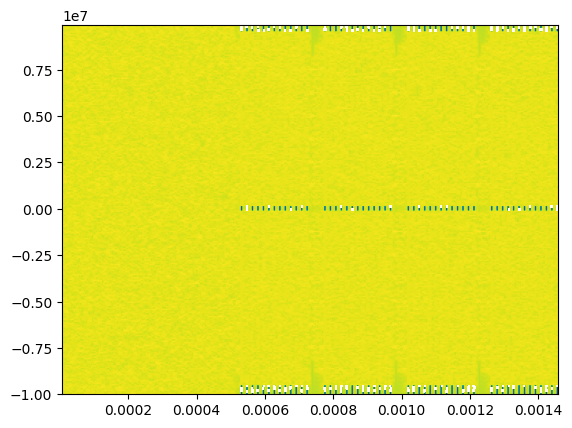

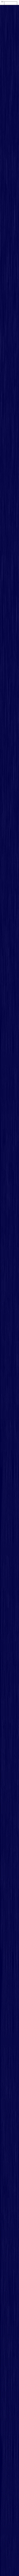

In [6]:


cam_class = SCORECAM_1dcnn(model, target_layer, slice_len)

#Create cam of single slice from trans example. For single plotting section below if debugging
#slice_of_trans = trans[37,:,:]#grab slice 0,Note 37 for debugging bad, 27 for good
# slice_of_trans[0,120:150] = torch.Tensor([np.random.randn(30)/8])
# slice_of_trans[1,120:150] = torch.Tensor([np.random.randn(30)/8])
#input_slice=slice_of_trans.expand(1,-1,-1)
#cam_output = cam_class.generate_cam(input_slice, target_class)


#generate maps for all slices in example
#Idea TODO:Create slice generator which allows arbitrary overlap inside of example trans
all_cams_in_trans = np.array([])
slice_accuracies = []
all_freq_cams_in_trans = []
for i in range(0,50):#range(0,len(trans)):
    #slice_of_trans = trans[i,:,:]
    slice_of_trans = many_slice_ts[i]
    print("og",slice_of_trans)
    og_pred=model(slice_of_trans).detach().cpu().numpy()
    print("Original Prediction",og_pred)
    #print(slice_of_trans.to('cpu').data.numpy())

    # #noise experiment to match power of signal
    if i <20 and i >=0:
        slice_of_trans_cpu = np.squeeze(slice_of_trans.to('cpu').data.numpy())
        #complex_slice = slice_of_trans.to('cpu').data.numpy()[0] + 1j*slice_of_trans.to('cpu').data.numpy()[1]
        complex_slice = slice_of_trans_cpu[0] +1j*slice_of_trans_cpu[1]
        total_power_original = np.sum(np.abs(complex_slice)**2)
        #total_power_original = 532.468 #class zero power
        noise_array = np.random.normal(size=slice_len) + 1j * np.random.normal(size=slice_len)
        total_power_noise = np.sum(np.abs(noise_array)**2)
        # Scale the noise array to match the total power of the original array
        scaling_factor = np.sqrt(total_power_original / total_power_noise)
        #scaling_factor = 0.001
        equal_power_noise = noise_array * scaling_factor
        real_part = np.real(equal_power_noise)  # Extract the real part
        imaginary_part = np.imag(equal_power_noise)  # Extract the imaginary part
        print("Powers:", i, total_power_original, total_power_noise, np.sum(np.abs(equal_power_noise)**2))
        #print(slice_of_trans_cpu.shape,slice_of_trans.shape)
        #print("before",slice_of_trans.shape,"zero index of slice of trans",slice_of_trans[0][0])
        slice_of_trans[0][0] = torch.Tensor(real_part)
        slice_of_trans[0][1] = torch.Tensor(imaginary_part)

        aug_pred=model(slice_of_trans).detach().cpu().numpy()
        print("Aug Prediction",aug_pred)

        #print(slice_of_trans.shape,"zero index of slice of trans",slice_of_trans[0][0])
        #slice_of_trans = slice_of_trans_cpu.unsqueeze(0)
        #complex_slice_noise = slice_of_trans.data.numpy()[0] + 1j*slice_of_trans.data.numpy()[1]
        rf_visualizer.trans_full_arr[i*slice_len:(i+1)*slice_len] =equal_power_noise

    # #freq offset experiment
    # if i < 20 and i >= 0:
    #     slice_of_trans_cpu = np.squeeze(slice_of_trans.to('cpu').data.numpy())
    #     complex_slice = slice_of_trans_cpu[0] + 1j * slice_of_trans_cpu[1]
    #     total_power_original = np.sum(np.abs(complex_slice)**2)
        
    #     # Frequency shift the complex slice
    #     freq_offset = 500 #in Hz
    #     t = np.arange(len(complex_slice)) / fs
    #     shifted_slice = complex_slice * np.exp(2j * np.pi * freq_offset * t)
        
    #     real_part = np.real(shifted_slice)  # Extract the real part
    #     imaginary_part = np.imag(shifted_slice)  # Extract the imaginary part
        
    #     print("Powers:", i, total_power_original, np.sum(np.abs(shifted_slice)**2))
        
    #     # Update the slice with the frequency-shifted version
    #     slice_of_trans[0][0] = torch.Tensor(real_part)
    #     slice_of_trans[0][1] = torch.Tensor(imaginary_part)
        
    #     # Update the full array
    #     rf_visualizer.trans_full_arr[i * slice_len:(i + 1) * slice_len] = shifted_slice
        
    input_slice=slice_of_trans.expand(1,-1,-1).to(model.device.type)
    cam_output,pred_class = cam_class.generate_cam(input_slice, target_class)
    freq_cams = cam_class.frequency_ablation_cam(input_slice, target_class, num_freq_divisions, filter_method='rectangular')

    #expand freq_cams to match df_size
    freq_cams_expanded_freq = np.repeat(freq_cams, input_slice.size(dim=2) // num_freq_divisions)
    freq_cams_expanded_freq = freq_cams_expanded_freq.reshape(1, -1)
    #Replicate this set along the time domain
    freq_cams_expanded_time = np.tile(freq_cams_expanded_freq, (input_slice.size(dim=2),1))

    all_freq_cams_in_trans.append(freq_cams_expanded_time)
    slice_accuracies.append(pred_class)
    # slice_of_trans_out = slice_of_trans.to("cpu")
    # out = model(slice_of_trans_out.float())
    # print("pred class", pred_class, out)
    all_cams_in_trans=np.append(all_cams_in_trans,cam_output)

all_freq_cams_in_trans = np.concatenate(all_freq_cams_in_trans, axis=0)
#print(all_freq_cams_in_trans.shape)
#print(all_cams_in_trans.shape)

# Extend accuracy values for each row in results_df
extended_accuracies = []
for acc in slice_accuracies:
    extended_accuracies.extend([acc] * input_slice.shape[2])  # len_per_slice is the number of rows per slice


title='test'
#rf_visualizer.plot_spec_with_time_cam_heatmap(all_cams_in_trans, title, fftWindow='rectangular', fftSize=256)

Fs = sample_rate
data = rf_visualizer.trans_full_arr
#print("data check", data[0],data[254:256], len(data))
fftWindow='rectangular'
fftSize=256
cams_arr = all_cams_in_trans
#create spectrogram background from original data
winLen = fftSize
overlap = fftSize-1
magnitude_data = np.abs(data)

import numpy as np
import matplotlib.pyplot as plt

# Assuming data is already loaded and is complex
magnitude_data = np.abs(data)  # Convert complex signal to magnitude
# print("Magnitude data shape:", magnitude_data.shape)
# print("Magnitude data type:", magnitude_data.dtype)
# print("First few elements of magnitude data:", magnitude_data[:10])
# Generate the spectrogram
spectrum, freqs, t, im = plt.specgram(magnitude_data, NFFT=fftSize, Fs=Fs)

# To display the spectrogram
plt.colorbar(im)  # Optional: Adds a color bar to the side showing the magnitude scale
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

if fftWindow == "rectangular":
    spectrum,freqs,t,im =plt.specgram(data, NFFT=fftSize, Fs=Fs, 
    window=lambda data: data*np.ones(winLen),  noverlap=overlap)
    #spectrum,freqs,t,im =plt.specgram(magnitude_data, NFFT=fftSize, Fs=Fs)
    transpose_spectrum = np.array(spectrum).T
    #print(len(data))
    #print(transpose_spectrum.shape)
    #plt.imshow(transpose_spectrum, aspect='auto', extent = [Fs/-2/1e6, Fs/2/1e6, 0, len(data)/Fs], interpolation = 'none',cmap ='gray')


#normalize cam for plotting
if np.min(cams_arr) != np.max(cams_arr):
    cam_final = (cams_arr - np.min(cams_arr)) / (np.max(cams_arr) - np.min(cams_arr))  # Normalize between 0-1
else:
    cam_final = (cams_arr - np.min(cams_arr)) 

# Reshape and normalize cam_arr to create cam_img
#print(cam_final)
cam_img = np.tile(cams_arr, (transpose_spectrum.shape[1], 1)).T  # Duplicate each row across W columns
print(cam_img)
cam_img = (cam_img * 255).astype(np.uint8)  # Convert to 8-bit format

#overlay heatmap on time axis according to cam
heatmap_img = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)

#prep section of spectrum corresponding to heatmap
transpose_spectrum_sliced = transpose_spectrum[0:len(heatmap_img),:]
transpose_spectrum_sliced = cv2.normalize(transpose_spectrum_sliced, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
transpose_spectrum_sliced = np.uint8(transpose_spectrum_sliced)
raw_spectrum_slice = transpose_spectrum_sliced.copy()
transpose_spectrum_sliced = cv2.cvtColor(transpose_spectrum_sliced, cv2.COLOR_GRAY2BGR)
transpose_spectrum_sliced = transpose_spectrum_sliced.astype(np.uint8)

print("about to superimpose",heatmap_img.shape,transpose_spectrum_sliced.shape)
super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, transpose_spectrum_sliced, 0.5, 0)

#save results
#cam_weight_time_data = np.random.rand(12800)

results_df = pd.DataFrame(raw_spectrum_slice)
results_df['IQ_data'] = data[0:len(heatmap_img)]
results_df['time_domain_CAM'] = cams_arr
# Add accuracy column to results_df
results_df['accuracy'] = extended_accuracies
for i in range(all_freq_cams_in_trans.shape[1]):  # Loop over each frequency bin
        results_df[f'fcam{i}'] = all_freq_cams_in_trans[:, i]
print(results_df.tail())
results_df.to_pickle(cur_dir+'/results/tPrime_no_chan_30SNR_debugging.pkl')

#show plot
fig = plt.figure(figsize=(super_imposed_img.shape[1]/100, super_imposed_img.shape[0]/100))
fig.figimage(super_imposed_img)
# fig.title(title)
# add_axes([xmin,ymin,dx,dy]) 
axes = fig.add_axes([0.5, 1, 0.5, 1])
# fig.xlabel("Frequency [MHz]")
# fig.ylabel("Time [s]")
fig.show()



## Optional code to plot a single cam rather than generate a batch

In [7]:

# plt.imshow(super_imposed_img, aspect='auto', extent = [Fs/-2/1e6, Fs/2/1e6, 0, len(cams_arr)/Fs], interpolation = 'none')
# plt.title(title)
# plt.xlabel("Frequency [MHz]")
# plt.ylabel("Time [s]")
# plt.show()


# Full forward pass
# conv_output is the output of convolutions at specified layer
# model_output is the final output of the model 
extractor = CamExtractor(model, target_layer)
conv_output, model_output = extractor.forward_pass(input_slice)
print("step1",input_slice.shape)

# #######################################freq cam steps for paper
# # Combine I and Q channels into a complex number
# #input_slice = input_slice.squeeze(0).transpose(0, 1)
# input_complex = input_slice[0].data.numpy()[0] + 1j*input_slice[0].data.numpy()[1]

# # Convert to numpy and apply FFT
# input_fft = fft(input_complex) #default to fft size = len input

# # Length of each frequency division
# division_length = input_fft.shape[0] // num_freq_divisions

# accuracy_weights = []
# filter_method = 'rectangular'
# for i in range(num_freq_divisions):
#     # Create a copy of the frequency domain representation
#     modified_fft = np.copy(input_fft)

#     # Calculate start and end indices for the current division
#     start_idx = i * division_length
#     end_idx = start_idx + division_length

#     # Apply notch filter (zero out the selected frequency band)
#     if filter_method == 'rectangular':
#         modified_fft[start_idx:end_idx] = 0
#     else:
#         print('Filter method: ', filter_method, " not recognized")
#         raise

#     # Convert back to time domain
#     modified_time_domain = ifft(modified_fft)
#     if i == num_freq_divisions/4:
#         modified_fft_to_plot = modified_fft
#         modified_time_domain_to_plot = modified_time_domain

# #########################################end freq cam


if target_class is None:
    target_class = np.argmax(model_output.data.numpy())

print("all logits", F.softmax(model_output,dim=1))
input_response_logit_Xb = F.softmax(model_output,dim=1)[0][target_class].data.numpy()
print("input response logit of target class", input_response_logit_Xb)
# Get convolution outputs
target = conv_output[0]
target = F.relu(target) #experimenting with Relu to try to fix negative targets
print("step2",target.shape,len(target))
# Create empty numpy array for cam
cam = np.ones(target.shape[1:], dtype=np.float32)
# Multiply each weight with its conv output and then, sum
#print(len(target))
test_var_weights = []
validate_cam_masks = []
validate_cam_Sc = []
validate_cam_Al_k = []
for i in range(len(target)): #iterate over each activation map
    # Unsqueeze
    saliency_map = torch.unsqueeze(torch.unsqueeze(target[i,:],0),0)

    # Upsampling to input size, from output feature size of 4 to 256 in this case
    saliency_map = F.interpolate(saliency_map, size=(256), mode='linear', align_corners=False)
    
    #skip the filters which have no response to input
    if saliency_map.max() == saliency_map.min():
        print("SKIPPING Filter")
        continue

    # Scale between 0-1
    norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
   
    # Get the target score
    X_Hl =input_slice*norm_saliency_map
    validate_cam_masks.append(X_Hl)
    validate_cam_Al_k.append(target[i, :].data.numpy())
    print("i, ", i)
    if i ==0:
        print("copying for methodology graphs:", X_Hl)
        copy_norm_saliency_map=X_Hl

    activation_map_score = extractor.forward_pass(X_Hl)[1]
    w = F.softmax(activation_map_score,dim=1)[0]
    w_class =w[target_class]
    validate_cam_Sc.append(w_class)
    test_var_weights.append(w_class)
    print("w_class",w_class)
    cam += w_class.data.numpy() * target[i, :].data.numpy() 

    print("cam",cam)
    print(w_class.data.numpy())
    # if w_class.data.numpy() > 0.90:
    #     print("breaking loop for debug")
    #     break

cam_final = transform.resize(cam, (256,))
cam_final = np.maximum(cam_final, 0)
print("target",target)
print("cam2",cam_final)
if np.min(cam_final) != np.max(cam_final):
    cam_output = (cam_final - np.min(cam_final)) / (np.max(cam_final) - np.min(cam_final))  # Normalize between 0-1
else:
    cam_output = (cam_final - np.min(cam_final)) #zero out
print("cam_output", cam_output)
#validation to original paper
S_c = [x.detach().numpy()-input_response_logit_Xb for x in validate_cam_Sc]
#print("s_c", S_c)
sum_alpha_cks = sum([math.exp(x)for x in S_c])
alpha_ck = [math.exp(x)/sum_alpha_cks for x in S_c]
#print("alpha_ck", alpha_ck, sum(alpha_ck))

cam_validation=np.ones(target.shape[1:], dtype=np.float32)
#print(validate_cam_Al_k)
for i in range(len(alpha_ck)):
    feature_cam_part=alpha_ck[i]*validate_cam_Al_k[i]
    #print(feature_cam_part)
    cam_validation += feature_cam_part
    #print(cam_validation)
cam_validation = transform.resize(cam_validation, (256,))
cam_validation = np.maximum(cam_validation, 0) #ReLu
cam_validation = (cam_validation - np.min(cam_validation)) / (np.max(cam_validation) - np.min(cam_validation))  # Normalize between 0-1
print("cam_val",cam_validation)


# #cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
# # cam = np.uint8(Image.fromarray(cam).resize((input_slice.shape[2],
# #                 input_slice.shape[3]), Image.ANTIALIAS))/255

#plot
original_slice_input = input_slice.squeeze()
class_label =3
pred = F.softmax(model(input_slice),dim=1)[0]
pred_acc_label = pred[target_class].data.numpy()

C = 0 #0=I, 1 =Q
channel_C_og_slice = original_slice_input[C,:].data.numpy()
#min_slice = np.min(channel_C_og_slice)
#original_slice_input_norm = (channel_C_og_slice - np.min(channel_C_og_slice)) / (np.max(channel_C_og_slice) - np.min(channel_C_og_slice))  # Normalize between 0-1
original_slice_input_norm = (channel_C_og_slice) / (np.max(channel_C_og_slice))  # Normalize between -1->1
title="True class label: "+str(class_label)+", Prediction probability of target "+str(target_class)+":"+str(pred_acc_label)+", Channel: "+str(C)
# method_plot_arr = np.abs(modified_fft_to_plot)/max(np.abs(modified_fft_to_plot))
# print(method_plot_arr)
# method_plot_arr = 2*(np.real(modified_time_domain_to_plot) - np.min(np.real(modified_time_domain_to_plot)))/(np.max(np.real(modified_time_domain_to_plot))-np.min(np.real(modified_time_domain_to_plot))) -1

fig = go.Figure([
go.Scatter(x=np.arange(0,len(original_slice_input[-1]),1),
            y=method_plot_arr,
                mode='lines',
                name='Raw signal')#,

# go.Scatter(x=np.arange(0,len(original_slice_input[-1]),1),
#                         y=cam_output,
#                         marker=dict(size=4),
#                 mode='lines+markers',
#                 name='Raw CAM',
#)
])

fig.update_layout(
title=title,
font=dict(size=20),
width=1600,
height=700,
yaxis_range=[-1,1],
paper_bgcolor='rgba(0,0,0,0)',
plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()





step1 torch.Size([1, 2, 512])
all logits tensor([[1.0000e+00, 1.2220e-09, 2.1013e-07, 6.7462e-17]],
       grad_fn=<SoftmaxBackward0>)
input response logit of target class 6.7461794e-17
step2 torch.Size([128, 251]) 128
SKIPPING Filter
SKIPPING Filter
SKIPPING Filter
SKIPPING Filter


RuntimeError: The size of tensor a (512) must match the size of tensor b (256) at non-singleton dimension 2

### Experimenting with TSNE

In [ ]:
from sklearn.manifold import TSNE
class TSNEExtractor():
    """
    Extracts CAM features from the model, this one is for AlexNet1D. May need to be tweaked for other models.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer  # Expecting a tuple ('conv' or 'fc', layer_index)
        self.conv_output = None  # This will store the output of the target layer

    def hook_layers(self):
        def get_activation(module, input, output):
            self.conv_output = output

        if self.target_layer[0] == 'conv':
            target = list(self.model.feature_extractor)[self.target_layer[1]]
        else:  # 'fc'
            fc_layers = [self.model.fc1, self.model.fc2, self.model.fc3]
            target = fc_layers[self.target_layer[1]]
        
        target.register_forward_hook(get_activation)

    def forward_pass(self, x):
        """
        Performs a forward pass on the model, capturing output from the targeted layer.
        """
        # Ensure we're hooking into the layers before the forward pass
        self.hook_layers()

        # Perform the forward pass through the model
        _ = self.model(x)

        # Return the captured output
        return self.conv_output

tsne_extractor = TSNEExtractor(model=model, target_layer=('fc', 1)) #1 is "fc2"
# Function to extract features
def extract_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        #for inputs, label in dataloader:
        for i, (trans, label) in enumerate(dataloader):
            trans, label = trans[0], label[0]
            slice_of_trans = trans[i,:,:]
        
            input_slice=slice_of_trans.expand(1,-1,-1)
            #print(i, input_slice)
            conv_output =tsne_extractor.forward_pass(input_slice)
            #print(conv_output)
            features.extend([conv_output[0].cpu().numpy()])
            labels.extend([label.data.numpy()])
    return np.array(features), np.array(labels)

features, labels = extract_features(model, dataloader)
print(features.shape,labels.shape)
features_flat = features.reshape(132, -1)  # Reshape to (132, 2048)
tsne = TSNE(n_components=2, verbose=1, perplexity=35, n_iter=1000)
tsne_results = tsne.fit_transform(features_flat)

print(len(tsne_results),len(labels))

# Plotting
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='viridis', alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))
plt.title('t-SNE visualization of model features')
plt.show()